In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
# matplotlib.use('pgf')

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import numpy as np

%matplotlib inline


c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

markerlist = ['o', 4, 5, 6, 7, 'p', 'd', 'P']


text_width = 5.5  # in  --> Confirmed with template explanation
text_height = 9.0

fs_m1 = 7  # for figure ticks 
fs = 9  # for regular figure text
fs_p1 = 10  # figure titles

axes_lw = 0.7

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('axes', linewidth=axes_lw)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title


matplotlib.rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})

matplotlib.rc('text', usetex=True)

plt.rcParams.update({'text.latex.preamble': r'\usepackage{amsfonts}'})

def remove_xticks(ax):
    for tick in ax.xaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
    ax.xaxis.set_tick_params(which='minor', bottom=False, top=False)
    ax.xaxis.set_tick_params(which='major', bottom=False, top=False)
    ax.set_xticklabels([])
        
def remove_yticks(ax):
    for tick in ax.yaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
    ax.yaxis.set_tick_params(which='minor', left=False)
    ax.set_yticklabels([])

In [2]:
import ml_collections
config = ml_collections.ConfigDict()

config.thompson = ml_collections.ConfigDict()
config.thompson.use_tpu = False

config.thompson.seed = 7
config.thompson.D = 1
config.thompson.model_name = "ExactGP"
config.thompson.kernel_name = "Matern32Kernel"
config.thompson.signal_scale = 1.0
config.thompson.length_scale = 0.1
config.thompson.noise_scale = 1e-3

config.thompson.n_features = 5000
config.thompson.n_init = 7
config.thompson.n_friends = 7
config.thompson.n_homies = 3
config.thompson.n_besties = 1

config.thompson.n_samples = 3

config.thompson.find_friends_method = 'uniform'
config.thompson.optim_lr = 1e-3
config.thompson.optim_iters = 100

config.thompson.grid_search_dim = 400

config.thompson.minval = 0.
config.thompson.maxval = 1.

In [3]:
import jax
import jax.numpy as jnp
from scalable_gps import kernels
from scalable_gps import thompson_utils
kernel_init_fn = getattr(kernels, config.thompson.kernel_name)
kernel = kernel_init_fn({'signal_scale': config.thompson.signal_scale,
                         'length_scale': jnp.array([config.thompson.length_scale])})
kernel.kernel_config['use_ard'] = False


key = jax.random.PRNGKey(config.thompson.seed)
init_key, optim_key = jax.random.split(key)
state = thompson_utils.init(init_key, config.thompson.D, kernel,
                            n_features=config.thompson.n_features, n_init=config.thompson.n_init,
                            noise_scale=config.thompson.noise_scale,
                            minval=config.thompson.minval, maxval=config.thompson.maxval)


In [4]:
### ExactGP
from scalable_gps.models.exact_gp_model import ExactGPModel
test_ds = thompson_utils.fake_dataset_like(state.ds)

exact_gp = ExactGPModel(noise_scale=config.thompson.noise_scale, kernel=kernel)
alpha_map, _ = exact_gp.compute_representer_weights(train_ds=state.ds, recompute=True)
print(alpha_map.shape)

friends_key = jax.random.PRNGKey(42)
x_friends = thompson_utils.find_friends(friends_key, 1, config.thompson.n_friends,
                                        method=config.thompson.find_friends_method,
                                        minval=config.thompson.minval,
                                        maxval=config.thompson.maxval,
                                        state=state,
                                        length_scale=jnp.array([config.thompson.length_scale]))
L_train = kernels.featurise(state.ds.x, state.feature_params)
L_test = kernels.featurise(test_ds.x, state.feature_params)
L = jnp.concatenate([L_train, L_test], axis=0)
print(L.shape)

samples_key = jax.random.PRNGKey(1337)
_, alpha_samples, w_samples = exact_gp.compute_posterior_samples(samples_key, config.thompson.n_samples, state.ds, test_ds, use_rff=True, L=L, zero_mean=False)
print(alpha_samples.shape, w_samples.shape)

acquisition_fn_sharex, acquisition_fn, acquisition_grad = thompson_utils.get_acquisition_fn(state, kernel, alpha_map, alpha_samples, w_samples)

y_friends = acquisition_fn_sharex(x_friends)
x_homies = thompson_utils.find_homies(x_friends, y_friends, config.thompson.n_homies)


x_besties, trace = thompson_utils.find_besties(x_homies, acquisition_fn, acquisition_grad,
                                               learning_rate=config.thompson.optim_lr,
                                               iterations=config.thompson.optim_iters,
                                               n_besties=config.thompson.n_besties,
                                               minval=config.thompson.minval,
                                               maxval=config.thompson.maxval,
                                               optim_trace=True)
print(x_friends.shape, x_homies.shape, x_besties.shape)
print(trace[0].shape, trace[1].shape)

(7,)
(8, 5000)
(3, 7) (3, 5000)
(7, 1) (3, 3, 1) (3, 1, 1)
(100, 3, 3, 1) (100, 3, 3)


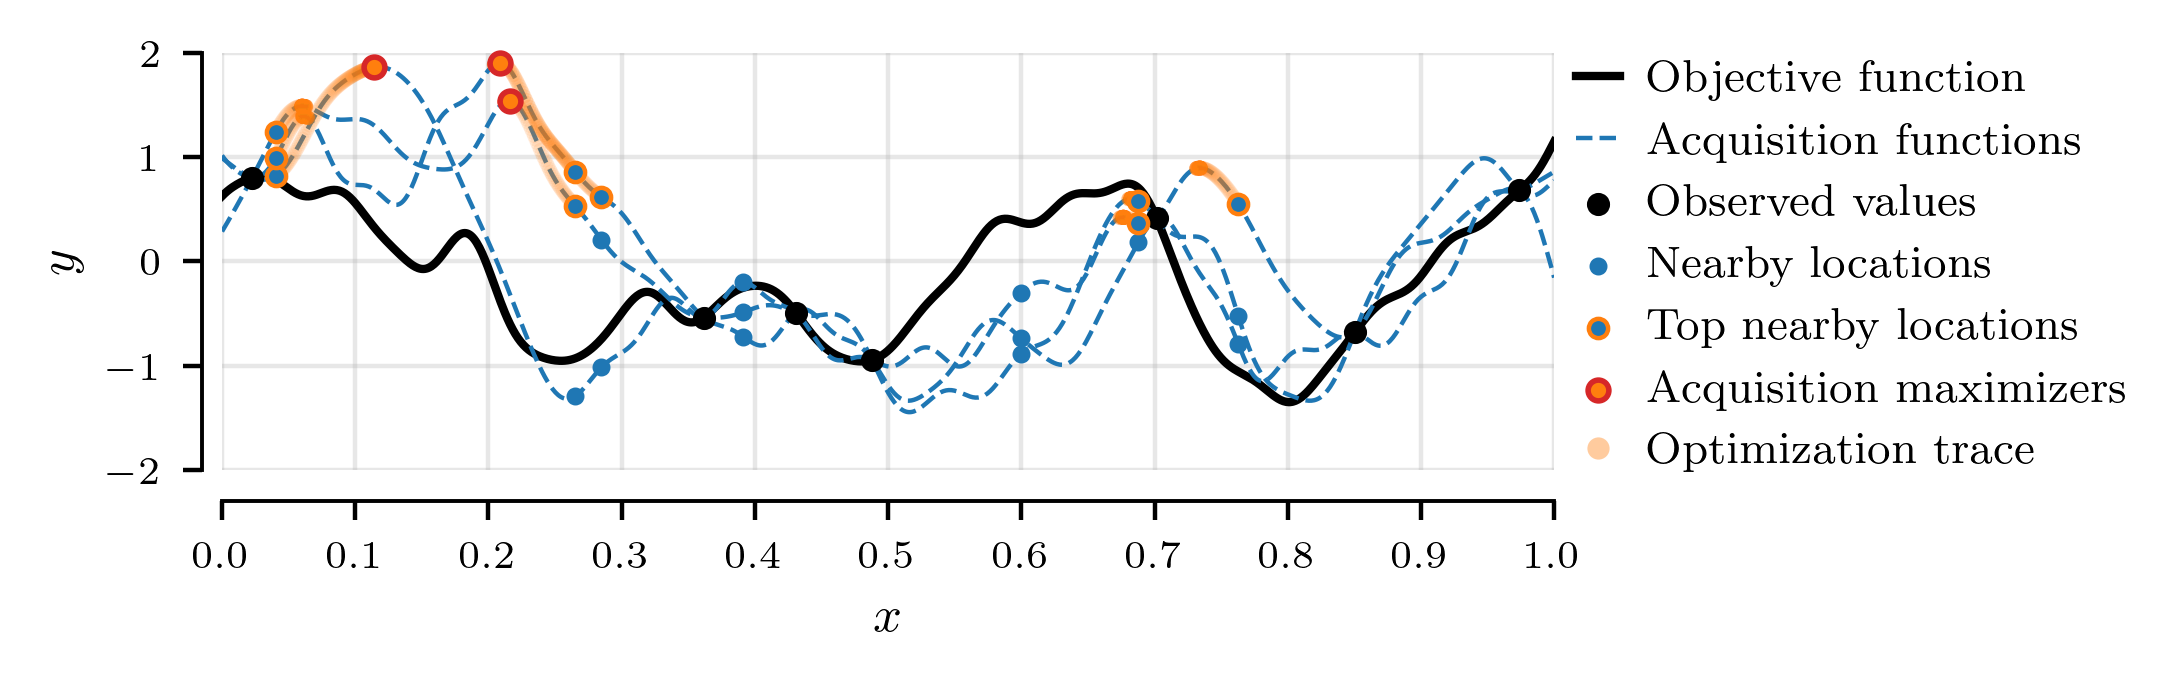

In [12]:
import matplotlib.pyplot as plt

n_plot = 1000
x_plot = jnp.linspace(config.thompson.minval, config.thompson.maxval, num=n_plot)[:, None]
L_plot = kernels.featurise(x_plot, state.feature_params)
y_plot = L_plot @ state.true_w

fig = plt.figure(dpi=400, figsize=[0.75 * text_width, 0.2 * text_height])
ax = fig.add_subplot(111)
ax.grid(alpha=0.3, zorder=0)
ax.spines[['top', 'right']].set_visible(False)
ax.spines['bottom'].set_position(('axes', -0.075))
ax.spines['left'].set_position(('axes', -0.015))

ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")

ax.set_xlim(config.thompson.minval, config.thompson.maxval)
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_ylim(-2, 2)

h1 = ax.plot(x_plot, y_plot, color='k', label='Objective function')
h2 = ax.scatter(state.ds.x, state.ds.y, color='k', marker='o', s=10, zorder=3, label='Observed values')
h3 = ax.plot(x_plot, acquisition_fn(x_plot[None, :].repeat(config.thompson.n_samples, axis=0)).T, color='tab:blue', linestyle='--', linewidth=0.8, label='Acquisition functions')
h4 = ax.scatter(x_friends.repeat(config.thompson.n_samples, axis=0), y_friends.T.ravel(), color='tab:blue', marker='o', s=5, zorder=3, alpha=1, label='Nearby locations')
h5 = ax.scatter(x_homies, acquisition_fn(x_homies), color='tab:blue', edgecolors='tab:orange', linewidth=0.8, linestyle='-', marker='o', s=12, zorder=3, alpha=1, label='Top nearby locations')
for i in range(config.thompson.optim_iters):
    x = trace[0][i]
    y = trace[1][i]
    ax.scatter(x, y, color='tab:orange', marker='o', edgecolors='none', s=7, zorder=2, alpha=0.1)
h7 = ax.scatter(x_besties, acquisition_fn(x_besties), color='tab:orange', edgecolors='tab:red', linewidth=1, marker='o', s=14, zorder=4, label='Acquisition maximizers', clip_on=False)

h6 = Line2D([], [], color='tab:orange', linestyle='None', marker='o', markeredgecolor='none', markersize=4, alpha=0.4, label='Optimization trace')
empty = Patch(edgecolor='none', facecolor='none', alpha=0.5)
fig.legend(handles=[h1[0], h3[0], h2, h4, h5, h7, h6], ncols=1, loc='center', bbox_to_anchor=(1.13, 0.61), handlelength=1, fontsize=8, frameon=False, handletextpad=0.6)

fig.tight_layout(w_pad=0.5, h_pad=0.2)
fig.savefig("../../figures/thompson_1D.png", bbox_inches='tight', pad_inches=0.01)
fig.savefig("../../figures/thompson_1D.pdf", bbox_inches='tight', pad_inches=0.01)